In [1]:
!pip install git+https://github.com/Farama-Foundation/MAgent2

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-v5xrgbq0
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-v5xrgbq0
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 37.0 MB/s eta 0:00:00
  Created wheel for magent2: filename=magent2-0.3.3-cp310-cp310-linux_x86_64.whl size=1696119 sha256=eee7efa0078fb7e4d237ff2fe6cf48d2a797002857b34a2e85ab18f4c0208330
  Stored in directory: /tmp/pip-ephem-wheel-cache-h69s3bnh/wheels/e4/8e/bf/51a30bc4038546e23b81c9fb513fe6a8fd916e5a9c5f4291d5
Successfully built magent2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import torch.nn as nn

class TzuSunNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super(TzuSunNetwork, self).__init__()

        height, width, channels = observation_shape

        self.cnn = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, observation_shape[-1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(observation_shape[-1]),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(observation_shape[-1]),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )

        # Calculate flattened size after CNN
        flattened_size = observation_shape[-1] * height * width

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_shape)
        )

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)  # Change from (1, 13, 13, 5) to (1, 5, 13, 13)
        x = self.cnn(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

Complete


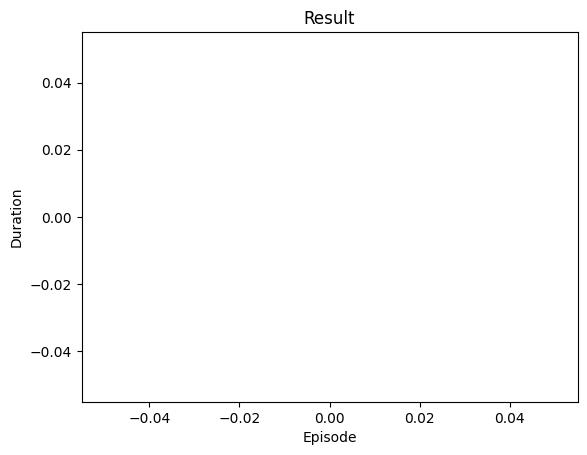

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
from collections import deque, namedtuple
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
from datetime import datetime
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from magent2.environments import battle_v4
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

env = battle_v4.env(map_size=45, minimap_mode=False, step_reward=0.001,
                        dead_penalty=-1, attack_penalty=-0.01, attack_opponent_reward=1,
                        max_cycles=200, extra_features=False, render_mode="rgb_array")

BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10
TAU = 0.005
LR = 1e-4

observation_shape = env.observation_space("blue_0").shape
action_shape = env.action_space("blue_0").n

policy_net = TzuSunNetwork(observation_shape, action_shape).to(device)
target_net = TzuSunNetwork(observation_shape, action_shape).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0

episode_rewards = []
episode_losses = []
running_loss = 0.0

def select_action(observation):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(observation).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space("blue_0").sample()]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 5 episode averages and plot them too
    if len(durations_t) >= 5:
        means = durations_t.unfold(0, 5, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(4), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    global running_loss

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    running_loss += loss.item()

    return loss.item()


num_episodes = 20

try:
    for i_episode in range(num_episodes):
        # Initialize the environment and get its state
        env.reset()
        episode_reward = 0
        running_loss = 0.0
        steps_done += 1

        for agent in env.agent_iter():

            observation, reward, termination, truncation, info = env.last()
            observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
            done = termination or truncation

            if done:
                action = None  # Agent is dead
                env.step(action)
            else:
                agent_handle = agent.split("_")[0]
                if agent_handle == "blue":

                    action = select_action(observation)

                    observation, reward, terminated, truncated, info = env.last()
                    observation = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                    env.step(action.item())

                    next_observation, reward, termination, truncation, info = env.last()
                    next_observation = torch.tensor(next_observation, dtype=torch.float32, device=device).unsqueeze(0)
                    reward = torch.tensor([reward], device=device, dtype=torch.float32)

                    # Store the transition in memory
                    memory.push(observation, action, next_observation, reward)

                    # Move to the next state
                    observation = next_observation

                    # Perform one step of the optimization (on the policy network)
                    optimize_model()

                    # Soft update of the target network's weights
                    # θ′ ← τ θ + (1 −τ )θ′
                    target_net_state_dict = target_net.state_dict()
                    policy_net_state_dict = policy_net.state_dict()
                    for key in policy_net_state_dict:
                        target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
                    target_net.load_state_dict(target_net_state_dict)
                else:
                    # red agent (random)
                    action = env.action_space("red_0").sample()
                    env.step(action)

            # Update episode reward
            episode_reward += reward

        # Add these lines at the end of each episode
        episode_rewards.append(episode_reward)
        episode_losses.append(running_loss)

        print(f'Episode {i_episode + 1}/{num_episodes}')
        print(f'Total Reward: {episode_reward.item():.2f}')
        print(f'Average Loss: {running_loss:.4f}')
        print(f'Epsilon: {EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY):.2f}')
        print('-' * 40)

        # Plot after each episode
        plot_durations()
    torch.save({
        'episode': i_episode,
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
    }, "models/blue.pt")
except KeyboardInterrupt:
    print('Interrupted')
    torch.save({
        'episode': i_episode,
        'policy_net_state_dict': policy_net.state_dict(),
        'target_net_state_dict': target_net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'episode_rewards': episode_rewards,
        'episode_losses': episode_losses,
    }, "models/blue.pt")
finally:
    print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()